In [1]:
import pandas as pd
import lightgbm as lgb
import load_datasets
import os
import time
from xgboost import XGBRegressor
import xgboost as xgb

# Load Data

In [2]:
training_name = 'xgboost'
X_train, y_train = load_datasets.train(max_date_block_num=32)
X_val, y_val = load_datasets.val()
X_test = load_datasets.test()

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [3]:
del X_train, y_train, X_val, y_val, X_test

# Model Training

In [4]:
ts = time.time()
params = {
    'max_depth': 10,
    'n_estimators': 1000,
    'min_child_weight': 0.5, 
    'colsample_bytree': 0.8, 
    'subsample': 0.8, 
    'eta': 0.1,
    'seed': 42,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

num_round=1000
model = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=30, verbose_eval=5)

time.time() - ts

[05:20:18] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:20:19] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.17517	eval-rmse:1.11763
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 30 rounds.
[5]	train-rmse:0.98677	eval-rmse:0.98502
[10]	train-rmse:0.89873	eval-rmse:0.93211
[15]	train-rmse:0.85151	eval-rmse:0.91534
[20]	train-rmse:0.82654	eval-rmse:0.90924
[25]	train-rmse:0.81103	eval-rmse:0.90662
[30]	train-rmse:0.79942	eval-rmse:0.90641
[35]	train-rmse:0.79129	

4964.219997882843

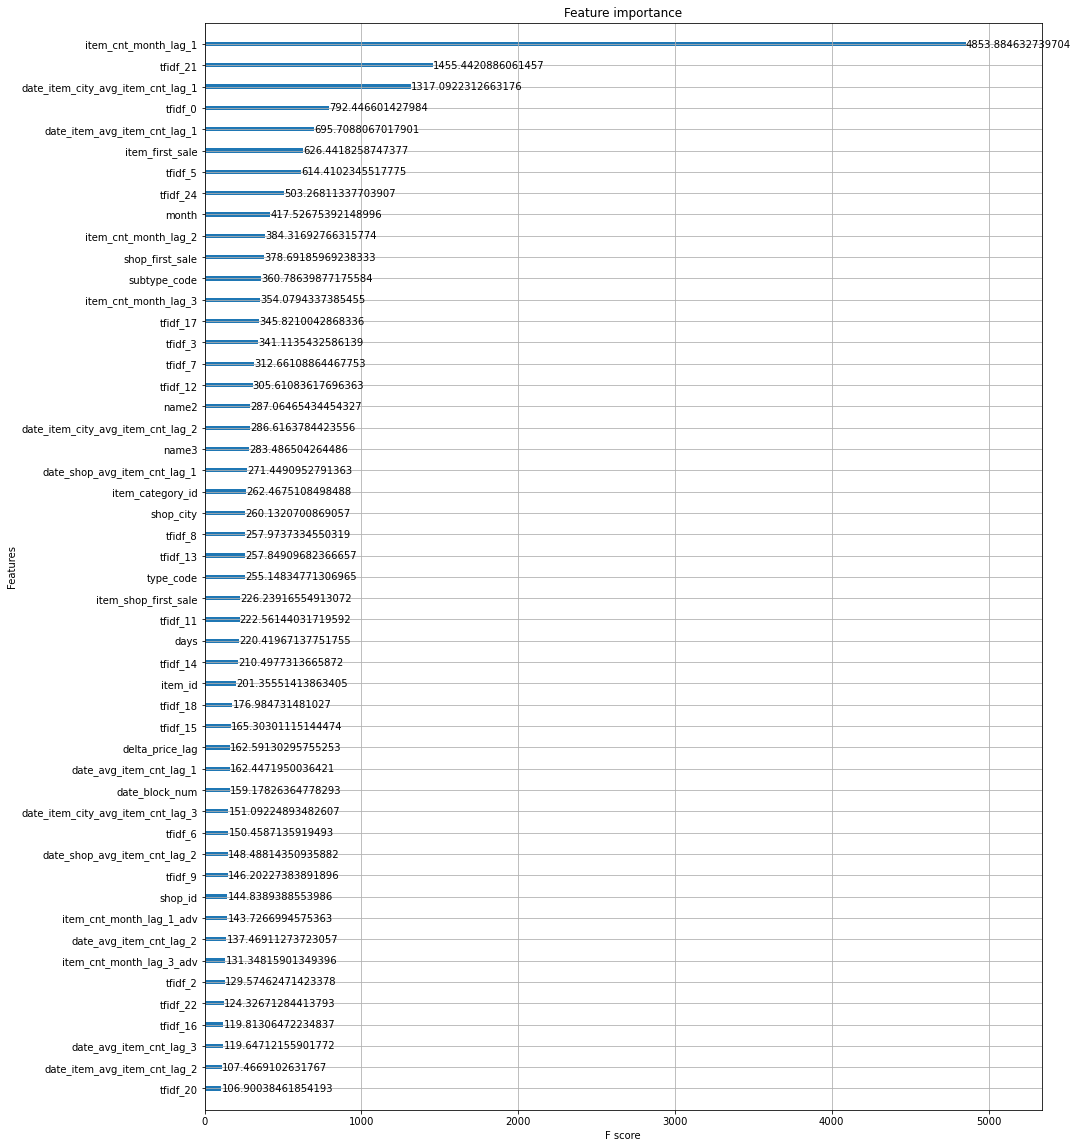

In [11]:
# plot importance
import matplotlib.pylab as plt
fig, ax = plt.subplots(1,1,figsize=(15, 20))
xgb.plot_importance(
    model, 
    ax=ax,
    max_num_features=50, 
    importance_type='gain')

# Make Prediction

In [5]:
DATA_DIR = "data"
OUTPUT_DIR = 'output'


pred_test = model.predict(dtest)


pred = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
pred['item_cnt_month'] = pred_test
pred['item_cnt_month'] = pred['item_cnt_month'].clip(lower=0, upper=20)
pred.to_csv(os.path.join(OUTPUT_DIR, training_name+'.csv'), index=False)

Your public LB scores are: 0.894218

In [6]:
# predict for val, and test for emsembling
pred_val = model.predict(dval)
pd.DataFrame({training_name + 'val': pred_val}).to_hdf(os.path.join(OUTPUT_DIR, training_name+'.h5'), key='val', mode='a')
pd.DataFrame({training_name + 'test': pred_test}).to_hdf(os.path.join(OUTPUT_DIR, training_name+'.h5'), key='test', mode='a')

In [7]:
model.save_model(os.path.join(OUTPUT_DIR, 'xgb_model.mdl'))